In [2]:
from docplex.mp.model import Model
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import qiskit as qk
import numpy as np
import math as m

## Implementing a classical solve of AQO on SAT

reference: [AQO on SAT](https://arxiv.org/pdf/quant-ph/0001106)

In [3]:
pauli_x = np.array([[0, 1], [1, 0]], dtype=np.float32)
pauli_z = np.array([[1, 0], [0, -1]], dtype=np.float32)
identity = np.identity(2)

Hp_i = 0.5 * (identity - pauli_z)  
Hb_i = 0.5 * (identity - pauli_x)

print("Qubit Problem Hamiltonian")
print(Hp_i)

print("Qubit Initial Hamiltonian")
print(Hb_i)

Qubit Problem Hamiltonian
[[0. 0.]
 [0. 1.]]
Qubit Initial Hamiltonian
[[ 0.5 -0.5]
 [-0.5  0.5]]


In [4]:
print(np.kron(Hp_i, identity))
print(np.kron(identity, Hp_i))

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [5]:
np.linalg.eigvals(
    np.array([
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1],
    ])
)

array([1., 0., 0., 1.])

In [6]:
num_qubits = 1
hamiltonian_shape = 2**num_qubits
initial_hamil = np.zeros((hamiltonian_shape, hamiltonian_shape))
problem_hamil = np.zeros((hamiltonian_shape, hamiltonian_shape))

for i in range(num_qubits):
    # Construct list
    problem_hamiltonian_i = np.zeros((num_qubits, 2, 2))
    initial_hamiltonian_i = np.zeros((num_qubits, 2, 2))
    for j in range(num_qubits):
        if i == j:
            problem_hamiltonian_i[j] = 0.5 * (identity - pauli_z)
            initial_hamiltonian_i[j] = 0.5 * (identity - pauli_x)
        else:
            problem_hamiltonian_i[j] = identity
            initial_hamiltonian_i[j] = identity

    problem_hamil += reduce(np.kron, problem_hamiltonian_i)
    initial_hamil += reduce(np.kron, initial_hamiltonian_i)

print(initial_hamil)
print(problem_hamil)

H = lambda s: (1 - s) * initial_hamil + s * problem_hamil 
# print(H(0))
# print(H(1))

[[ 0.5 -0.5]
 [-0.5  0.5]]
[[0. 0.]
 [0. 1.]]


In [7]:
print(np.linalg.eigvals(initial_hamil))
print(np.linalg.eigvals(problem_hamil))

[1.00000000e+00 1.11022302e-16]
[0. 1.]


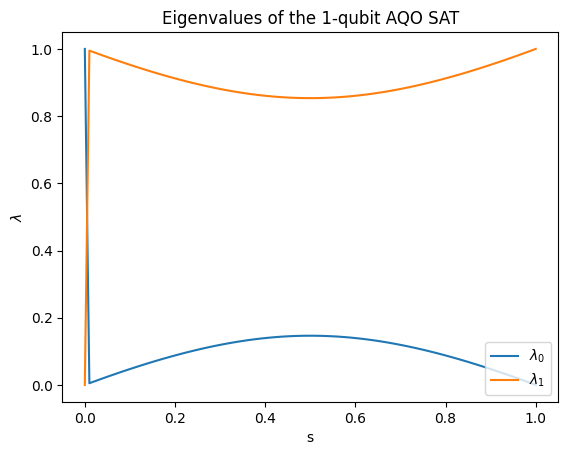

In [8]:
num_vals = 100
eigvals = np.zeros((num_vals, 2**num_qubits))
s_space = np.linspace(0., 1., num_vals)
for i, s in enumerate(s_space):
    eigvals[i,:] = np.linalg.eigvals(H(s))

plt.title(f"Eigenvalues of the {num_qubits}-qubit AQO SAT")
plt.xlabel("s")
plt.ylabel("$\lambda$")
for i in range(2**num_qubits):
    plt.plot(s_space, eigvals[:,i], label=f"$\lambda_{i}$")
plt.legend(loc="lower right")
# _ = sns.lineplot(eigvals[1], ax=ax)

## Classical AQO

What is the goal of AQO?

To solve for the ground state (lowest eigenvalue) of a Hamiltonian. The eigenvector associated with that eigenvalue is our solution to an optimisation problem.

For example: If we are trying to optimise some function $C: {0,1}^n -> \mathbb{R}$ (a function with binary string input of length $n$). If we have some way to encode $C$ into a Hamiltonian $H_P$ where the eigenvectors of $H_P$ are a binary string of length $n$, and the eigenvalues are the value of $C$ at the eigenvector ket-string (qubit-register), then just computing the eigenvalues of $H_P$ will give the minimum or maximum input.

However, this eigenvalue computation may be expensive (hamiltonians get very big and its $O(n^2)$ to determine the eigenvalue where $n$ is the matrix size ($\mathbb{C}^n\times n$) [QR Algorithm](https://people.inf.ethz.ch/arbenz/ewp/Lnotes/chapter4.pdf))
If we work with $n$ as the number of qubits, our hamiltonian grows at $2^n$, so the eigenvalue complexity is $O(2^{2n})$.
This makes a classical approach difficult and another technique to solve for eigenvalues is required.

AQO works by slowly nudging our state towards the desired eigenstate through the slow transfrom of $H_i$ to $H_P$ where we set the initial statevector as the minimum (or max) eigenvector.
Then just measuring the quantum state should collapse into the minimum energy eigenstate that we can just read off.

> AQO is not about solving for $H_P$, it is about calculating the minimum eigenvalue of $H_P$

In [9]:
pauli_x = np.array([[0, 1], [1, 0]], dtype=np.complex64)
pauli_y = np.array([[0, -1j], [1j, 0]], dtype=np.complex64)
pauli_z = np.array([[1, 0], [0, -1]], dtype=np.complex64)
identity = np.identity(2, dtype=np.complex64)

In [10]:
def build_initial_hamiltonian(graph_order: int) -> np.ndarray[np.complex64]:
    num_qubits = int(m.floor(graph_order * (graph_order - 1) / 2))
    result = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex64)
    for i in range(num_qubits):
        matrices = np.zeros((num_qubits, 2, 2), dtype=np.complex64)
        for j in range(num_qubits):
            if i == j:
                matrices[j] = 0.5 * (identity - pauli_x)
            else:
                matrices[j] = identity

        result += reduce(np.kron, matrices)

    return result
    
def build_clique_H(graph_order: int, clique_order: int) -> np.ndarray[np.complex64]:
    num_qubits = int(m.floor(graph_order * (graph_order - 1) / 2))

    clique_result = identity
    for _ in range(m.comb(clique_order, 2)):
        clique_result = np.matmul(clique_result, 0.5 * (identity - pauli_z))

    result = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex64)
    for i in range(num_qubits):
        matrices = np.zeros((num_qubits, 2, 2), dtype=np.complex64)
        for j in range(num_qubits):
            if i == j:
                matrices[j] = clique_result
            else:
                matrices[j] = identity

        result += reduce(np.kron, matrices)

    return result

def build_iset_H(graph_order: int, clique_order: int) -> np.ndarray[np.complex64]:
    num_qubits = int(m.floor(graph_order * (graph_order - 1) / 2))

    iset_result = identity
    for _ in range(m.comb(clique_order, 2)):
        iset_result = np.matmul(iset_result, 0.5 * (identity + pauli_z))

    result = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex64)
    for i in range(num_qubits):
        matrices = np.zeros((num_qubits, 2, 2), dtype=np.complex64)
        for j in range(num_qubits):
            if i == j:
                matrices[j] = iset_result 
            else:
                matrices[j] = identity

        result += reduce(np.kron, matrices)

    return result


In [11]:
graph_order = 3
num_qubits = int(m.floor(graph_order * (graph_order - 1) / 2))
initial_hamiltonian = build_initial_hamiltonian(graph_order)
clique_H = build_clique_H(graph_order, 3)
iset_H = build_iset_H(graph_order, 3)
hamiltonian = lambda s: (1 - s) * initial_hamiltonian + s * (clique_H + iset_H)
print(clique_H)

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j]]


In [12]:
print(np.linalg.eigvals(clique_H)) 
print(np.linalg.eigvals(iset_H))

[0.+0.j 1.+0.j 1.+0.j 2.+0.j 1.+0.j 2.+0.j 2.+0.j 3.+0.j]
[3.+0.j 2.+0.j 2.+0.j 1.+0.j 2.+0.j 1.+0.j 1.+0.j 0.+0.j]


In [13]:
discrete_length = 10
s_space = np.linspace(0., 1., discrete_length)
hamiltonians = np.zeros((discrete_length, 2**num_qubits, 2**num_qubits), dtype=np.complex64)

for i in range(discrete_length):
    hamiltonians[i] = hamiltonian(s_space[i]) 

print((hamiltonians[0] - initial_hamiltonian < 0.01).all())
# print((hamiltonians[discrete_length - 1] - problem_hamiltonian < 0.01).all())

True


In [14]:
print(np.linalg.eigvals(hamiltonians[-1]))

[3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j]


In [15]:
from queue import LifoQueue
from copy import deepcopy

def enumerate_choices(n: int, r: int) -> list:
    choices = []
    stack = LifoQueue()
    stack.put([])

    while not stack.empty():
        item = stack.get()

        if len(item) == r:
            choices.append(item)
        else:
            start_idx = (item[-1] + 1) if len(item) > 0 else 0
            for i in range(start_idx, n):
                new_item = deepcopy(item)
                new_item.append(i)
                stack.put(new_item)

    return choices

In [16]:
P0 = 0.5 * (identity + pauli_z)
P1 = 0.5 * (identity - pauli_z)

# n -> size of the produce space (i.e. number of qubits in graph)
# i -> qubit position
# k -> size of interested slice (i.e. number of qubits in subgraph)
def build_p1(n: int, i: int):
    qubit_matrices = np.zeros((n, 2, 2), dtype=np.complex64)
    qubit_matrices[:,0,0] = 1
    qubit_matrices[:,1,1] = 1
    qubit_matrices[i] = P1

    p1 = reduce(np.kron, qubit_matrices)
    return p1

def build_p0(n: int, i: int):
    qubit_matrices = np.zeros((n, 2, 2), dtype=np.complex64)
    qubit_matrices[:,0,0] = 1
    qubit_matrices[:,1,1] = 1
    qubit_matrices[i] = P0

    p0 = reduce(np.kron, qubit_matrices)
    return p0

def build_H(n: int, k: int, qubit_hamiltonian):
    H = np.zeros((2**n, 2**n), dtype=np.complex64)
    E_alpha = enumerate_choices(n, k)
    for alpha in range(m.comb(n, k)):
        H_alpha = np.identity(2**n)
        for i in range(m.comb(k, 2)):
            H_alpha = np.matmul(H_alpha, qubit_hamiltonian(n, E_alpha[alpha][i]))

        H += H_alpha

    return H

In [21]:
print(build_p1(3, 0).astype(np.float32))
print(build_p1(3, 1).astype(np.float32))
print(build_p1(3, 2).astype(np.float32))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


C:\Users\Orwellian\AppData\Local\Temp\ipykernel_6676\686364762.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(build_p1(3, 0).astype(np.float32))
C:\Users\Orwellian\AppData\Local\Temp\ipykernel_6676\686364762.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  print(build_p1(3, 1).astype(np.float32))
C:\Users\Orwellian\AppData\Local\Temp\ipykernel_6676\686364762.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  print(build_p1(3, 2).astype(np.float32))


In [17]:
g_n = 3
c_n = 2
is_n = 3

n = g_n * (g_n - 1) // 2
k = c_n * (c_n - 1) // 2
l = is_n
print(n, k, l)
H_clique = build_H(n, k, build_p1)
H_iset = build_H(n, l, build_p0)
print(H_clique)
# print(H_iset)
# H = H_clique + H_iset
# H = H_iset
H = H_clique
# print(H)

print("Eigenvalues")
H_eigs = np.linalg.eig(H)
H_test = H_eigs.eigenvalues > 0
print("num non-zero eigenvalues =", np.sum(H_test))
print("num zero eigenvalues =", np.sum(np.invert(H_test)))
print(H_eigs.eigenvalues)

3 1 3
[[3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j]]
Eigenvalues
num non-zero eigenvalues = 8
num zero eigenvalues = 0
[3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j]


In [18]:
def H(start, end, s):
    return (1 - s) * start + s * end 

def U(l1_delta, l_delta, start, end):
    return np.exp(-1j * (l1_delta - l_delta) * H(start, end, l_delta))
    # return H(start, end, l_delta)

test_start = np.zeros((2,2))
test_end = np.ones((2,2)) * 2

print(H(test_start, test_end, 0.))
print(H(test_start, test_end, 1.))
# print(U(1.1, 1., test_start, test_end))

[[0. 0.]
 [0. 0.]]
[[2. 2.]
 [2. 2.]]


In [19]:
num_steps = 100
num_qubits = 1

def build_simple_Hb(num_qubits: int) -> np.ndarray[np.complex64]:
    result = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex64)
    for i in range(num_qubits):
        matrices = np.zeros((num_qubits, 2, 2), dtype=np.complex64)
        for j in range(num_qubits):
            if i == j:
                matrices[j] = 0.5 * (identity - pauli_x)
            else:
                matrices[j] = identity

        result += reduce(np.kron, matrices)

    return result

# start_H = build_simple_Hb(num_qubits)
# end_H = np.identity(2**num_qubits) * 5
start_H = np.zeros((2**num_qubits, 2**num_qubits))
end_H = np.ones((2**num_qubits, 2**num_qubits))

test_ket = np.ones(2**num_qubits) / 2**(num_qubits/2)

discretised_space = np.linspace(0., 1., num_steps)
operators = np.zeros((num_steps - 1, 2**num_qubits, 2**num_qubits), dtype=complex)
for i in range(num_steps - 1):
    operators[i] = U(discretised_space[i + 1], discretised_space[i], start_H, end_H)
print(operators[0])
print(operators[-1])

np.set_printoptions(linewidth=180)
state_ket = test_ket
for i in range(operators.shape[0]):
    state_ket = np.matmul(operators[i], state_ket)

print(state_ket)

[[1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j]]
[[0.99995001-0.00999881j 0.99995001-0.00999881j]
 [0.99995001-0.00999881j 0.99995001-0.00999881j]]
[3.94397036e+29-2.12880796e+29j 3.94397036e+29-2.12880796e+29j]
